In [1]:
import torch
from datasets import load_dataset
from torch.utils.data import DataLoader
import warnings
warnings.filterwarnings("ignore")

/mnt/disk1/sumdev/CourseWork/a3_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load Dataset and Create Dataloader

In [2]:
# Load training dataset, only the first 50,000 examples
train_dataset = load_dataset("wmt16", "de-en", split="train[:50000]")

# Load validation and test datasets
validation_dataset = load_dataset("wmt16", "de-en", split="validation")
test_dataset = load_dataset("wmt16", "de-en", split="test")

In [3]:
len(train_dataset), len(validation_dataset), len(test_dataset)

(50000, 2169, 2999)

# Setup- 2C

### Load Model

In [5]:
import torch
from transformers import T5ForConditionalGeneration, T5Tokenizer, T5Config, AutoTokenizer
from torch.utils.data import Dataset, DataLoader

# Load the T5 tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("google-t5/t5-small")
model = T5ForConditionalGeneration.from_pretrained("google-t5/t5-small")

### Make Layers Trainable

In [16]:
for param in model.parameters():
    param.requires_grad = False

# Make first two layer of model's encoder trainable
for param in model.encoder.block[:2].parameters():
    param.requires_grad = True

# Make last three layer of model's decoder trainable
for param in model.decoder.block[-3:].parameters():
    param.requires_grad = True

# Make first two layer of model's decoder trainable
for param in model.decoder.block[:2].parameters():
    param.requires_grad = True
    
# Make last three layer of model's decoder trainable
for param in model.decoder.block[-3:].parameters():
    param.requires_grad = True

### Create Dataset and Dataloader

In [6]:
from torch.nn.utils.rnn import pad_sequence

# Define a custom dataset class for German-to-English translation
class TranslationDataset(Dataset):
    def __init__(self, data, tokenizer):
        self.data = data
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        german = self.tokenizer.encode(sample['translation']['de'], return_tensors='pt')
        english = self.tokenizer.encode(sample['translation']['en'], return_tensors='pt')
        return german.squeeze(0), english.squeeze(0)
    


def my_collate_fn(batch):
    src_batch, tgt_batch = zip(*batch)
    src_batch = pad_sequence(src_batch, batch_first=True, padding_value=tokenizer.pad_token_id)
    tgt_batch = pad_sequence(tgt_batch, batch_first=True, padding_value=tokenizer.pad_token_id)
    return src_batch, tgt_batch


# Create DataLoader with custom collate function
BATCH_SIZE = 64
train_data = TranslationDataset(train_dataset, tokenizer)
val_data = TranslationDataset(validation_dataset, tokenizer)
test_data = TranslationDataset(test_dataset, tokenizer)
print(len(train_data), len(val_data), len(test_data))

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, collate_fn=my_collate_fn)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False, collate_fn=my_collate_fn)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False, collate_fn=my_collate_fn)
print(len(train_loader), len(val_loader), len(test_loader))

# Iterate through the DataLoader
for german_batch, english_batch in train_loader:
    print(german_batch.shape, english_batch.shape)
    break

50000 2169 2999
782 34 47
torch.Size([64, 157]) torch.Size([64, 132])


### Finetune the T5 Model

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss = torch.nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id)

model = model.to(device)

In [19]:
EPOCH = 5
training_loss = []
validation_loss = []

for epoch in range(EPOCH):
    train_loss = 0
    model.train()
    for i, (german_batch, english_batch) in enumerate(train_loader):
        german_batch, english_batch = german_batch.to(device), english_batch.to(device)
        optimizer.zero_grad()
        output = model(input_ids=german_batch, labels=english_batch)
        batch_loss = loss(output.logits.view(-1, output.logits.shape[-1]), english_batch.view(-1))
        batch_loss.backward()
        optimizer.step()
        train_loss += batch_loss.item()
        if i % 100 == 0:
            print(f"Batch {i}, Loss: {batch_loss.item()}")
    train_loss = train_loss / len(train_loader)
    training_loss.append(train_loss)
    
    val_loss = 0
    model.eval()
    with torch.no_grad():
        for german_batch, english_batch in val_loader:
            german_batch, english_batch = german_batch.to(device), english_batch.to(device)
            output = model(input_ids=german_batch, labels=english_batch)
            val_loss += loss(output.logits.view(-1, output.logits.shape[-1]), english_batch.view(-1)).item()
    val_loss /= len(val_loader)
    validation_loss.append(val_loss)
    
    print(f"Epoch {epoch+1}: Training loss: {train_loss}, Validation loss: {val_loss}")

Batch 0, Loss: 7.614135265350342
Batch 100, Loss: 3.1174025535583496
Batch 200, Loss: 2.707453966140747
Batch 300, Loss: 2.7780606746673584
Batch 400, Loss: 2.5667431354522705
Batch 500, Loss: 2.685753583908081
Batch 600, Loss: 2.5662221908569336
Batch 700, Loss: 2.568875312805176
Epoch 1: Training loss: 2.735836673270711, Validation loss: 2.266573323922999
Batch 0, Loss: 2.517554521560669
Batch 100, Loss: 2.436403274536133
Batch 200, Loss: 2.381542682647705
Batch 300, Loss: 2.429607629776001
Batch 400, Loss: 2.1286587715148926
Batch 500, Loss: 2.2541277408599854
Batch 600, Loss: 2.4473628997802734
Batch 700, Loss: 2.2143986225128174
Epoch 2: Training loss: 2.3576214069600607, Validation loss: 2.177361958167132
Batch 0, Loss: 2.139035224914551
Batch 100, Loss: 2.1552021503448486
Batch 200, Loss: 2.1624841690063477
Batch 300, Loss: 2.1933677196502686
Batch 400, Loss: 2.150977611541748
Batch 500, Loss: 2.1644322872161865
Batch 600, Loss: 2.2550320625305176
Batch 700, Loss: 2.272300243377

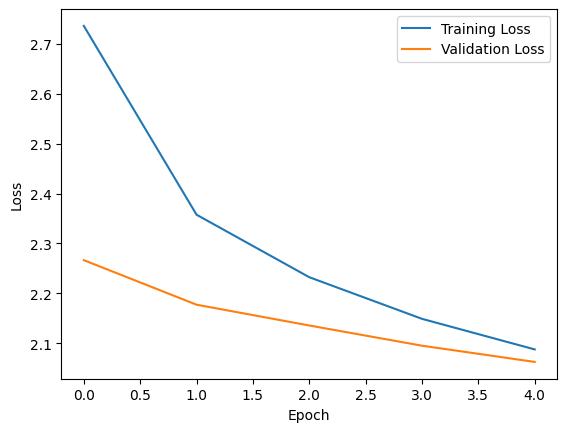

In [20]:
import matplotlib.pyplot as plt

plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [10]:
def evaluate(model, loader, criterion):
    model.eval()
    model = model.to(device)
    total_loss = 0
    with torch.no_grad():
        for german_batch, english_batch in loader:
            german_batch, english_batch = german_batch.to(device), english_batch.to(device)
            output = model(input_ids=german_batch, labels=english_batch)
            total_loss += criterion(output.logits.view(-1, output.logits.shape[-1]), english_batch.view(-1)).item()
    return total_loss / len(loader)

print("Validation Loss:", evaluate(model, val_loader, loss))
print("Test Loss:", evaluate(model, test_loader, loss))

Validation Loss: 2.06270426161149
Test Loss: 1.8900803733379283


### Save the Model

In [137]:
model = model.to('cpu')
torch.save(model.state_dict(), 'q2c_t5_model.pth')

In [11]:
import torch
from transformers import T5ForConditionalGeneration, T5Tokenizer, T5Config, AutoTokenizer
from torch.utils.data import Dataset, DataLoader

# Load the T5 tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("google-t5/t5-small")
model_loaded = T5ForConditionalGeneration.from_pretrained("google-t5/t5-small")
model_loaded.load_state_dict(torch.load('q2c_t5_model.pth'))

print("Validation Loss:", evaluate(model_loaded, val_loader, loss))
print("Test Loss:", evaluate(model_loaded, test_loader, loss))

Validation Loss: 2.06270426161149
Test Loss: 1.8900803733379283


### Compute the Evaluation Scores

In [12]:
ind = 1
print(test_dataset[ind]['translation']['de'])
print(test_dataset[ind]['translation']['en'])

sentence = test_dataset[ind]['translation']['de']
input_ids = tokenizer(sentence, return_tensors="pt").input_ids

model = model_loaded.to(device)
input_ids = input_ids.to(device)
outputs = model.generate(input_ids)
print(tokenizer.decode(outputs[0], skip_special_tokens=True))

Das Verhältnis zwischen Obama und Netanyahu ist nicht gerade freundschaftlich.
The relationship between Obama and Netanyahu is not exactly friendly.
The relationship between Obama and Netanyahu is not particularly frenetic.


In [17]:
import sacrebleu
from nltk.translate import meteor_score
from nltk.tokenize import word_tokenize
from bert_score import score
import nltk
nltk.download('wordnet')
nltk.download('punkt')


def calculate_bleu(predicted_corpus, reference_corpus):
    return sacrebleu.corpus_bleu(predicted_corpus, [[i] for i in reference_corpus])

def calculate_meteor(predicted_corpus, reference_corpus):
    m_score = 0
    for line in zip(predicted_corpus, reference_corpus):
        hypo = word_tokenize(line[0])
        ref = word_tokenize(line[1])
        # m_score += meteor_score.meteor_score([ref], hypo)
        m_score += meteor_score.single_meteor_score(ref, hypo)
    return m_score / len(reference_corpus)

def calculate_bert_score(predicted_corpus, reference_corpus):
    p, r, f1 = score(predicted_corpus, reference_corpus, lang="de")
    return p.mean().item(), r.mean().item(), f1.mean().item()

def translate_sentence(finetuned_model, dataset):
    finetuned_model = finetuned_model.to(device)
    sentence_german = []
    sentence_english = []
    sentence_english_translated = []
    for i in range(len(dataset)):
        sentence_german.append(dataset[i]['translation']['de'])
        sentence_english.append(dataset[i]['translation']['en'])
        input_ids = tokenizer(sentence_german[i], return_tensors="pt").input_ids
        input_ids = input_ids.to(device)
        outputs = finetuned_model.generate(input_ids)
        sentence_english_translated.append(tokenizer.decode(outputs[0], skip_special_tokens=True))
    return sentence_german, sentence_english, sentence_english_translated

[nltk_data] Downloading package wordnet to
[nltk_data]     /mnt/disk1/sumdev/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /mnt/disk1/sumdev/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Evaluation Scores on the Validation Set

In [18]:
sentence_german_val, sentence_english_val, sentence_english_translated_val = translate_sentence(model_loaded, validation_dataset)

bleu_score_val = calculate_bleu(sentence_english_translated_val, sentence_english_val)
meteor_score_val = calculate_meteor(sentence_english_translated_val, sentence_english_val)
bert_score_val = calculate_bert_score(sentence_english_translated_val, sentence_english_val)

print(f'BLEU Score: {bleu_score_val.score}')
print(f'BLEU-1 Score: {bleu_score_val.precisions[0]}')
print(f'BLEU-2 Score: {bleu_score_val.precisions[1]}')
print(f'BLEU-3 Score: {bleu_score_val.precisions[2]}')
print(f'BLEU-4 Score: {bleu_score_val.precisions[3]}')
print(f'METEOR Score: {meteor_score_val}')
print(f'BERT Scores:')
print(f'Precision in BERT Score: {bert_score_val[0]}')
print(f'Recall in BERT Score: {bert_score_val[1]}')
print(f'F1 Score in BERT Score: {bert_score_val[2]}')

BLEU Score: 11.478744233307168
BLEU-1 Score: 70.0
BLEU-2 Score: 11.11111111111111
BLEU-3 Score: 6.25
BLEU-4 Score: 3.5714285714285716
METEOR Score: 0.3227082170618216
BERT Scores:
Precision in BERT Score: 0.79283207654953
Recall in BERT Score: 0.7551372647285461
F1 Score in BERT Score: 0.7728002071380615


'\nBLEU Score: 11.478744233307168\nBLEU-1 Score: 70.0\nBLEU-2 Score: 11.11111111111111\nBLEU-3 Score: 6.25\nBLEU-4 Score: 3.5714285714285716\nMETEOR Score: 0.3227082170618216\n\n'

In [21]:
for i in range(5):
    print('==> Sentence', i+1)
    print(f'German: {sentence_german_val[i]}')
    print(f'English: {sentence_english_val[i]}')
    print(f'Translated: {sentence_english_translated_val[i]}')

==> Sentence 1
German: Die Premierminister Indiens und Japans trafen sich in Tokio.
English: India and Japan prime ministers meet in Tokyo
Translated: The Premier Minister Indiens and Japan trafiqued in Tokio.
==> Sentence 2
German: Indiens neuer Premierminister Narendra Modi trifft bei seinem ersten wichtigen Auslandsbesuch seit seinem Wahlsieg im Mai seinen japanischen Amtskollegen Shinzo Abe in Toko, um wirtschaftliche und sicherheitspolitische Beziehungen zu besprechen.
English: India's new prime minister, Narendra Modi, is meeting his Japanese counterpart, Shinzo Abe, in Tokyo to discuss economic and security ties, on his first major foreign visit since winning May's election.
Translated: Indi' s new Premier Narendra Modi will be addressing his first international
==> Sentence 3
German: Herr Modi befindet sich auf einer fünftägigen Reise nach Japan, um die wirtschaftlichen Beziehungen mit der drittgrößten Wirtschaftsnation der Welt zu festigen.
English: Mr Modi is on a five-day tr

### Evaluation Scores on the Test Set

In [19]:
sentence_german_test, sentence_english_test, sentence_english_translated_test = translate_sentence(model_loaded, test_dataset)

bleu_score_test = calculate_bleu(sentence_english_translated_test, sentence_english_test)
meteor_score_test = calculate_meteor(sentence_english_translated_test, sentence_english_test)
bert_score_test = calculate_bert_score(sentence_english_translated_test, sentence_english_test)

print(f'BLEU Score: {bleu_score_test.score}')
print(f'BLEU-1 Score: {bleu_score_test.precisions[0]}')
print(f'BLEU-2 Score: {bleu_score_test.precisions[1]}')
print(f'BLEU-3 Score: {bleu_score_test.precisions[2]}')
print(f'BLEU-4 Score: {bleu_score_test.precisions[3]}')
print(f'METEOR Score: {meteor_score_test}')
print(f'BERT Scores:')
print(f'Precision in BERT Score: {bert_score_test[0]}')
print(f'Recall in BERT Score: {bert_score_test[1]}')
print(f'F1 Score in BERT Score: {bert_score_test[2]}')

BLEU Score: 0.0
BLEU-1 Score: 66.66666666666667
BLEU-2 Score: 25.0
BLEU-3 Score: 25.0
BLEU-4 Score: 0.0
METEOR Score: 0.35205323785503273
BERT Scores:
Precision in BERT Score: 0.8002291321754456
Recall in BERT Score: 0.7628726363182068
F1 Score in BERT Score: 0.7803449034690857


'\nBLEU Score: 0.0\nBLEU-1 Score: 66.66666666666667\nBLEU-2 Score: 25.0\nBLEU-3 Score: 25.0\nBLEU-4 Score: 0.0\nMETEOR Score: 0.35205323785503273\nBERT Scores:\nPrecision in BERT Score: 0.8002291321754456\nRecall in BERT Score: 0.7628726363182068\nF1 Score in BERT Score: 0.7803449034690857\n'

In [20]:
for i in range(5):
    print('==> Sentence', i+1)
    print(f'German: {sentence_german_test[i]}')
    print(f'English: {sentence_english_test[i]}')
    print(f'Translated: {sentence_english_translated_test[i]}')

==> Sentence 1
German: Obama empfängt Netanyahu
English: Obama receives Netanyahu
Translated: Obama senounces Netanyahu
==> Sentence 2
German: Das Verhältnis zwischen Obama und Netanyahu ist nicht gerade freundschaftlich.
English: The relationship between Obama and Netanyahu is not exactly friendly.
Translated: The relationship between Obama and Netanyahu is not particularly frenetic.
==> Sentence 3
German: Die beiden wollten über die Umsetzung der internationalen Vereinbarung sowie über Teherans destabilisierende Maßnahmen im Nahen Osten sprechen.
English: The two wanted to talk about the implementation of the international agreement and about Teheran's destabilising activities in the Middle East.
Translated: The two men wanted to speak about the implementation of the international agreement and about the Teheran
==> Sentence 4
German: Bei der Begegnung soll es aber auch um den Konflikt mit den Palästinensern und die diskutierte Zwei-Staaten-Lösung gehen.
English: The meeting was also